In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
LR = 0.001
CNN_EPOCHS = 5 
 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 4 * 4, 10)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc(x)
        return x

# Initialize Model
cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LR)

# 3. Train CNN
print(f"--- Training CNN on {device} ---")
for epoch in range(CNN_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.3f}")

print("CNN Training Finished.\n")

--- Training CNN on cuda ---
Epoch 1, Loss: 1.485
Epoch 2, Loss: 1.090
Epoch 3, Loss: 0.928
Epoch 4, Loss: 0.826
Epoch 5, Loss: 0.752
CNN Training Finished.



In [3]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, expansion_factor=4):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim * expansion_factor
        self.encoder = nn.Linear(input_dim, self.hidden_dim)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(self.hidden_dim, input_dim, bias=False)
        nn.init.kaiming_uniform_(self.encoder.weight)
        nn.init.normal_(self.decoder.weight, std=0.01)
        self.b_dec = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = self.relu(self.encoder(x_cent))
        recon = self.decoder(acts) + self.b_dec
        return recon, acts

    def normalize_decoder_weights(self):
        with torch.no_grad():
            self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

In [32]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

SAE_EPOCHS = 5
SAE_LR = 3e-4
L1_COEFF = 1e-3

# Register hooks
cnn.conv1.register_forward_hook(get_activation('conv1'))
cnn.conv2.register_forward_hook(get_activation('conv2'))
cnn.conv3.register_forward_hook(get_activation('conv3'))

def collect_activations(layer_name, num_batches=50):
    buffer = []
    cnn.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(trainloader):
            if i >= num_batches: break
            inputs = inputs.to(device)
            _ = cnn(inputs)
            act = activations[layer_name] 
            act = act.permute(0, 2, 3, 1).reshape(-1, act.shape[1])
            buffer.append(act)
            
    return torch.cat(buffer, dim=0)

saes = {}
layer_dims = {'conv1': 16, 'conv2': 32, 'conv3': 64}

print("--- Training SAEs ---")

for layer_name, dim in layer_dims.items():
    print(f"Training SAE for {layer_name} (Input Dim: {dim})...")
    data = collect_activations(layer_name, num_batches=50) # Approx 50*128*32*32 vectors for conv1
    sae = SparseAutoencoder(input_dim=dim, expansion_factor=16).to(device)
    optimizer_sae = optim.Adam(sae.parameters(), lr=SAE_LR)
    batch_size_sae = 4096
    num_samples = data.shape[0]
    
    for epoch in range(SAE_EPOCHS):
        perm = torch.randperm(num_samples)
        data = data[perm]
        
        epoch_loss = 0
        epoch_recon = 0
        epoch_l1 = 0
        
        for i in range(0, num_samples, batch_size_sae):
            batch = data[i:i+batch_size_sae]
            if len(batch) < 10: continue
            
            optimizer_sae.zero_grad()
            
            recon, latents = sae(batch)
            
            # Loss: MSE + L1 Penalty
            recon_loss = nn.functional.mse_loss(recon, batch)
            l1_loss = L1_COEFF * latents.sum(dim=1).mean() # Average L1 norm per vector
            
            loss = recon_loss + l1_loss
            
            loss.backward()
            optimizer_sae.step()
            sae.normalize_decoder_weights()
            
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_l1 += l1_loss.item()
            
        # Logging
        steps = (num_samples // batch_size_sae)
        if epoch == SAE_EPOCHS - 1:
            print(f"  End Epoch {epoch+1}: MSE: {epoch_recon/steps:.5f} | L1: {epoch_l1/steps:.5f}")
            active_percent = (latents > 0).float().mean().item() * 100
            print(f"  Active Neurons: {active_percent:.2f}%")
    saes[layer_name] = sae

--- Training SAEs ---
Training SAE for conv1 (Input Dim: 16)...
  End Epoch 5: MSE: 0.00074 | L1: 0.00288
  Active Neurons: 9.33%
Training SAE for conv2 (Input Dim: 32)...
  End Epoch 5: MSE: 0.00148 | L1: 0.00574
  Active Neurons: 6.78%
Training SAE for conv3 (Input Dim: 64)...
  End Epoch 5: MSE: 0.08705 | L1: 0.09081
  Active Neurons: 14.99%


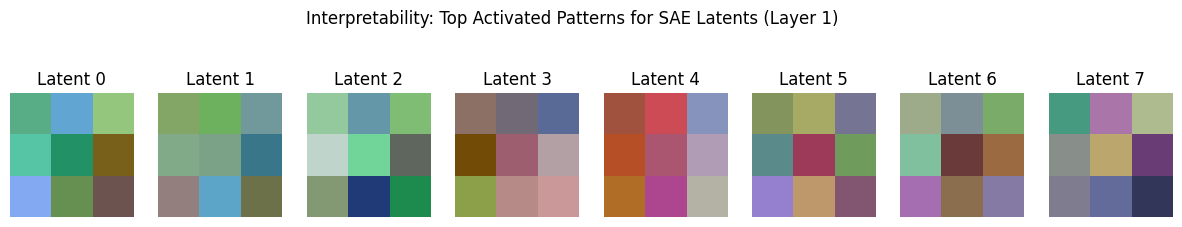

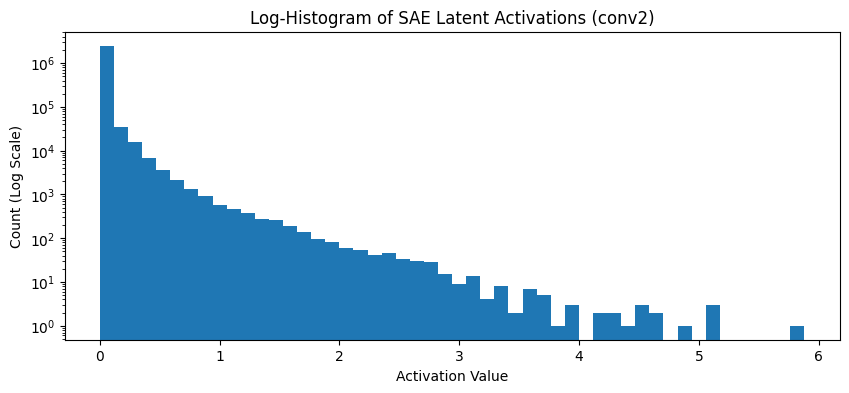


--- Reconstruction Inspection (First 3 channels of 1 sample) ---
Original:    [-0.16  0.09 -0.17]
Reconstruct: [-0.12  0.01 -0.15]


In [33]:
def visualize_sae_features_conv1(cnn, sae_conv1, num_features=10):
    W_cnn = cnn.conv1.weight.detach().view(16, -1) 
    W_sae = sae_conv1.decoder.weight.detach().t() 
    projected_features = torch.matmul(W_sae, W_cnn).view(-1, 3, 3, 3)
    projected_features = projected_features - projected_features.min()
    projected_features = projected_features / projected_features.max()
    fig, axs = plt.subplots(1, num_features, figsize=(15, 3))
    plt.suptitle("Interpretability: Top Activated Patterns for SAE Latents (Layer 1)")
    
    for i in range(num_features):
        feat = projected_features[i].cpu().numpy()
        feat = np.transpose(feat, (1, 2, 0)) 
        feat_large = np.kron(feat, np.ones((10, 10, 1))) 
        
        axs[i].imshow(feat_large)
        axs[i].axis('off')
        axs[i].set_title(f"Latent {i}")
    plt.show()

def analyze_sparsity_histogram(layer_name, sae, data):
    with torch.no_grad():
        _, latents = sae(data[:5000])
    
    latents_np = latents.cpu().numpy().flatten()
    
    plt.figure(figsize=(10, 4))
    plt.hist(latents_np, bins=50, log=True)
    plt.title(f"Log-Histogram of SAE Latent Activations ({layer_name})")
    plt.xlabel("Activation Value")
    plt.ylabel("Count (Log Scale)")
    plt.show()

visualize_sae_features_conv1(cnn, saes['conv1'], num_features=8)
data_conv2 = collect_activations('conv2', num_batches=5)
analyze_sparsity_histogram('conv2', saes['conv2'], data_conv2)
inputs = data_conv2[:5]
recon, _ = saes['conv2'](inputs)

print("\n--- Reconstruction Inspection (First 3 channels of 1 sample) ---")
print(f"Original:    {inputs[0, :3].cpu().numpy().round(2)}")
print(f"Reconstruct: {recon[0, :3].detach().cpu().numpy().round(2)}")

In [34]:
def visualize_max_activating(cnn, sae, layer_name, trainloader, num_features=5):
    print(f"--- Finding Max Activating Images for {layer_name} ---")
    current_acts = {}
    def get_act(name):
        def hook(model, input, output):
            current_acts[name] = output.detach()
        return hook
    handle = getattr(cnn, layer_name).register_forward_hook(get_act(layer_name))
    
    max_activations = {i: (-1.0, None) for i in range(num_features)}
    
    cnn.eval()
    sae.eval()
    scan_batches = 10 
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(trainloader):
            if batch_idx >= scan_batches: break
            images = images.to(device)
            
            _ = cnn(images)
            act = current_acts[layer_name]
            b, c, h, w = act.shape
            act_flat = act.permute(0, 2, 3, 1).reshape(-1, c)
            
            # Run SAE
            _, latents = sae(act_flat) #
            latents = latents.view(b, h, w, -1)
            for feat_idx in range(num_features):
                feat_map = latents[:, :, :, feat_idx]
                batch_max = feat_map.max()
                
                if batch_max > max_activations[feat_idx][0]:
                    flat_idx = torch.argmax(feat_map)
                    img_idx = flat_idx // (h * w) 
                    
                    best_img = images[img_idx].cpu()
                    max_activations[feat_idx] = (batch_max.item(), best_img)
    
    handle.remove() 
    fig, axs = plt.subplots(1, num_features, figsize=(15, 4))
    plt.suptitle(f"Max Activating Images for {layer_name} SAE Features")
    
    for i in range(num_features):
        val, img = max_activations[i]
        if img is not None:
            img = img / 2 + 0.5 
            np_img = np.transpose(img.numpy(), (1, 2, 0))
            
            axs[i].imshow(np_img)
            axs[i].set_title(f"Latent {i}\nAct: {val:.2f}")
        axs[i].axis('off')
    plt.show()

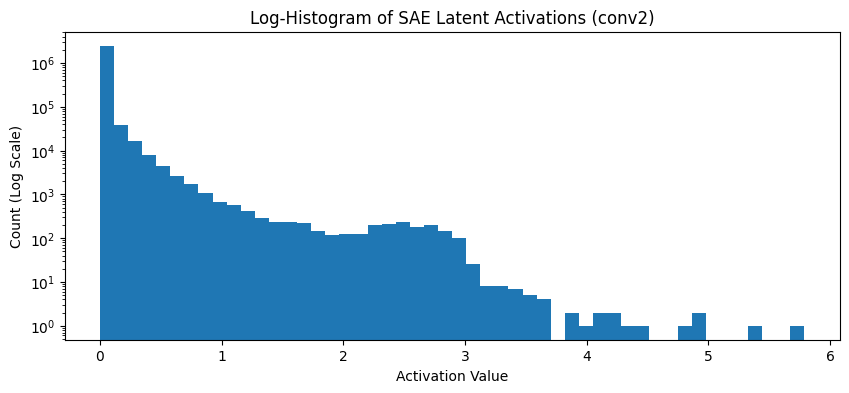


--- Conv2 Reconstruction (First 3 channels) ---
Original:    [-0.39 -0.16 -0.19]
Reconstruct: [-0.39 -0.2  -0.21]
--- Finding Max Activating Images for conv2 ---


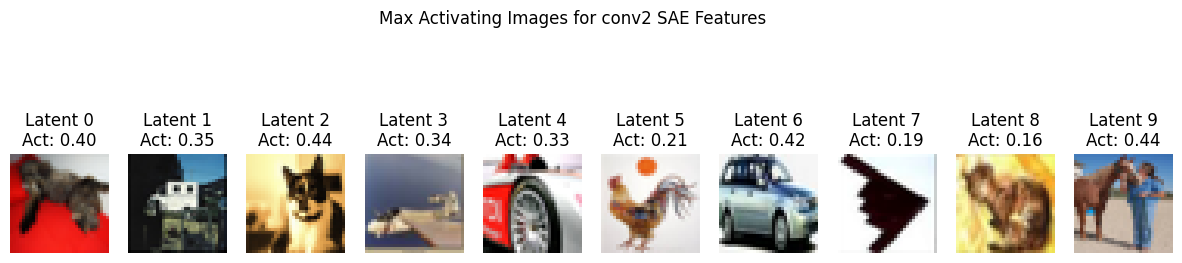

In [35]:
# 1. Histogram
data_conv2 = collect_activations('conv2', num_batches=50)
analyze_sparsity_histogram('conv2', saes['conv2'], data_conv2)

# 2. Reconstruction Check
inputs = data_conv2[:5]
recon, _ = saes['conv2'](inputs)
print("\n--- Conv2 Reconstruction (First 3 channels) ---")
print(f"Original:    {inputs[0, :3].cpu().numpy().round(2)}")
print(f"Reconstruct: {recon[0, :3].detach().cpu().numpy().round(2)}")

# 3. Visualize what images trigger the features
visualize_max_activating(cnn, saes['conv2'], 'conv2', trainloader, num_features=10)

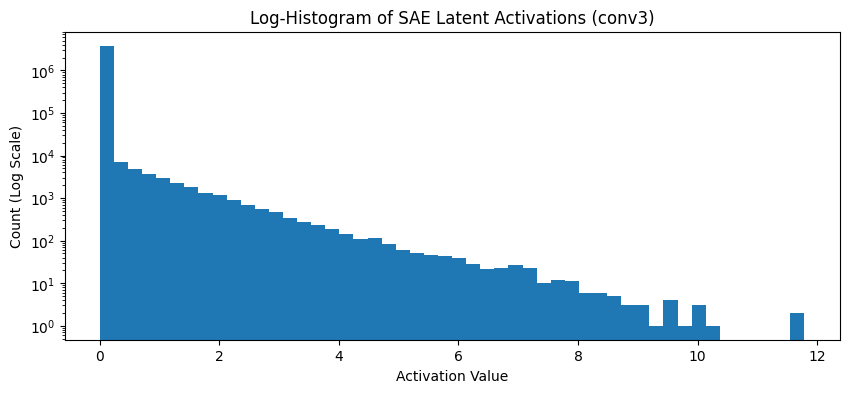


--- Conv3 Reconstruction (First 3 channels) ---
Original:    [-0.91 -0.46  0.32]
Reconstruct: [-0.74 -0.44 -0.1 ]
--- Finding Max Activating Images for conv3 ---


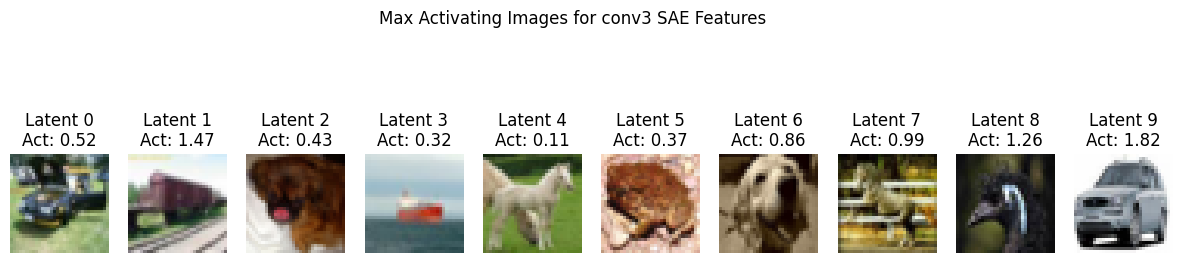

In [19]:
data_conv3 = collect_activations('conv3', num_batches=15) 
analyze_sparsity_histogram('conv3', saes['conv3'], data_conv3)

# 2. Reconstruction Check
inputs = data_conv3[:5]
recon, _ = saes['conv3'](inputs)
print("\n--- Conv3 Reconstruction (First 3 channels) ---")
print(f"Original:    {inputs[0, :3].cpu().numpy().round(2)}")
print(f"Reconstruct: {recon[0, :3].detach().cpu().numpy().round(2)}")

visualize_max_activating(cnn, saes['conv3'], 'conv3', trainloader, num_features=10)

Analyzing conv1 to find most important features...


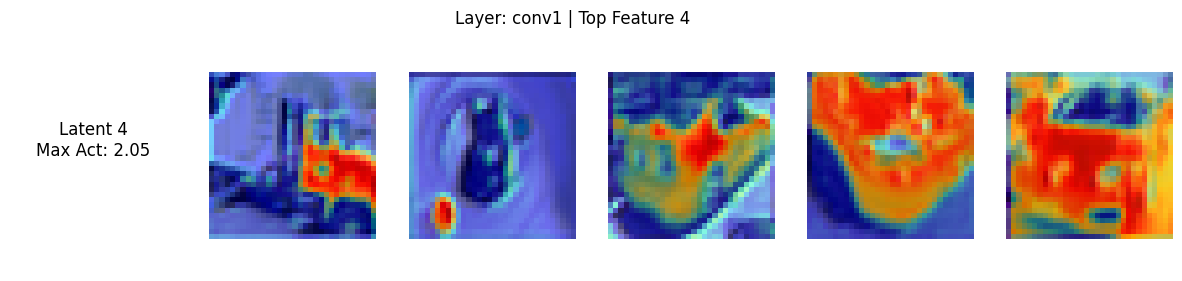

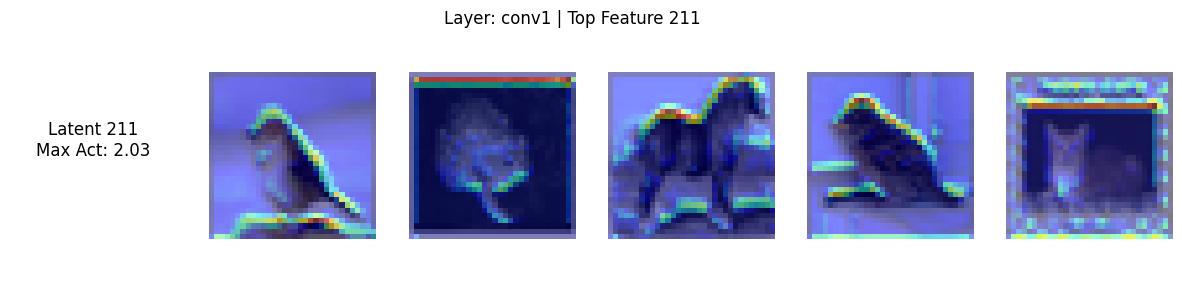

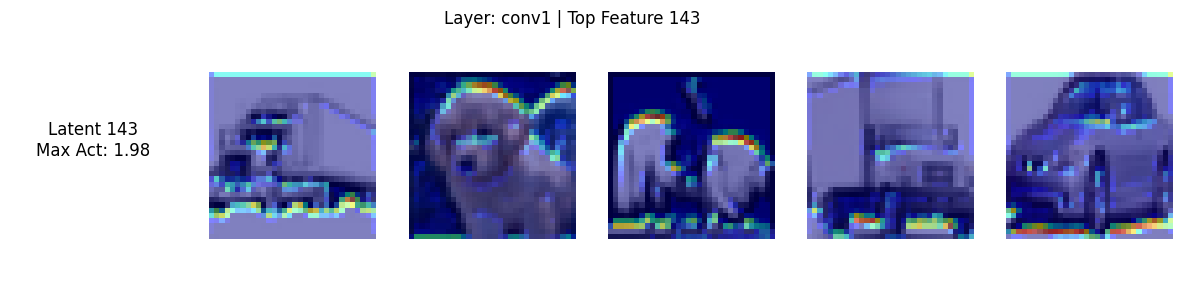

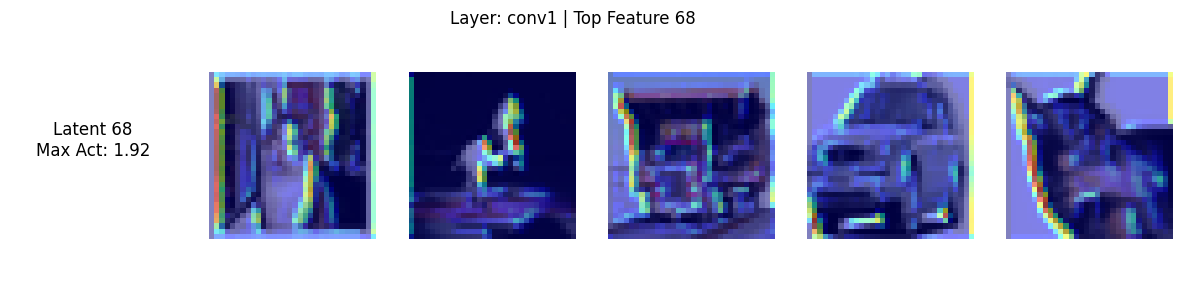

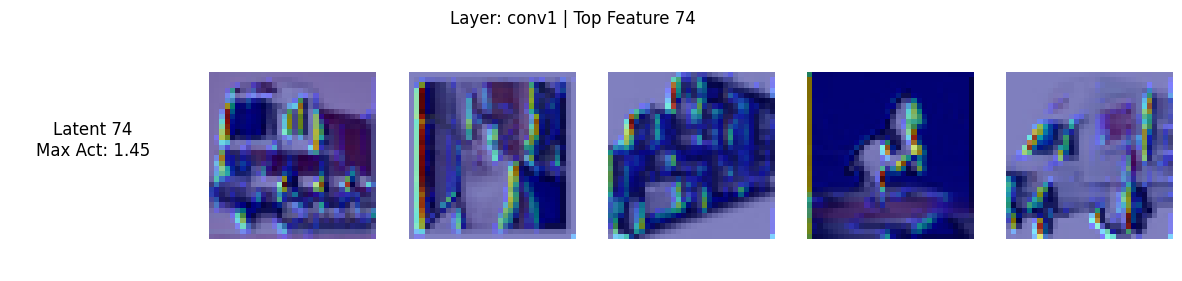

Analyzing conv2 to find most important features...


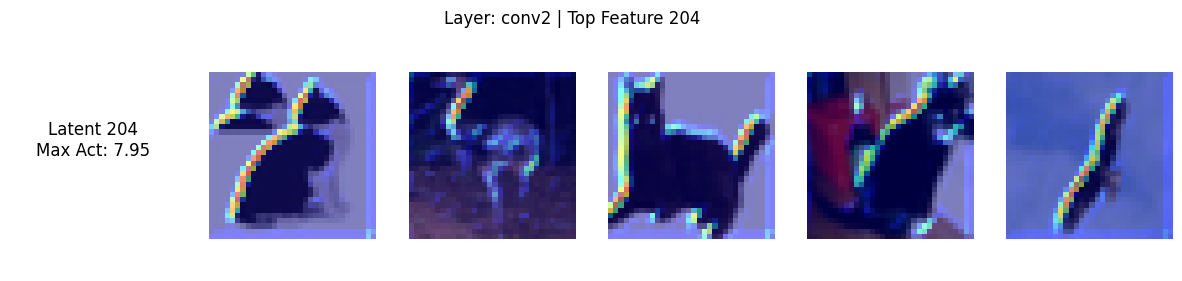

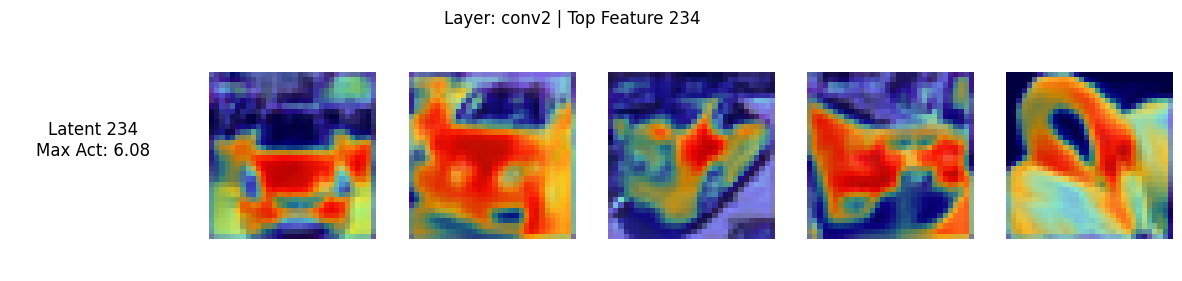

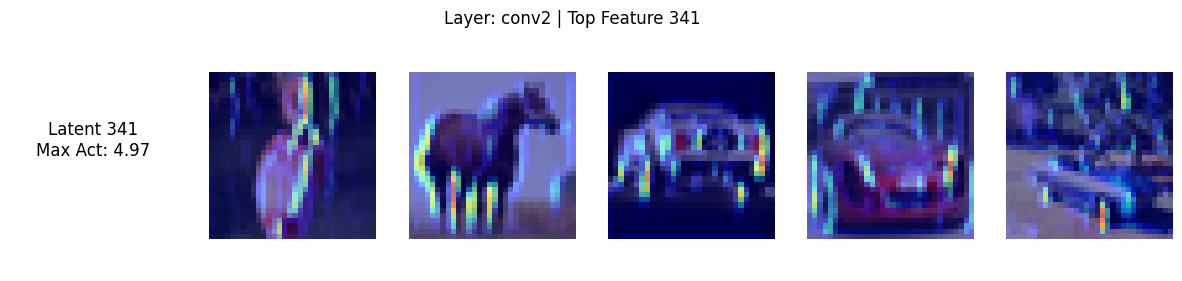

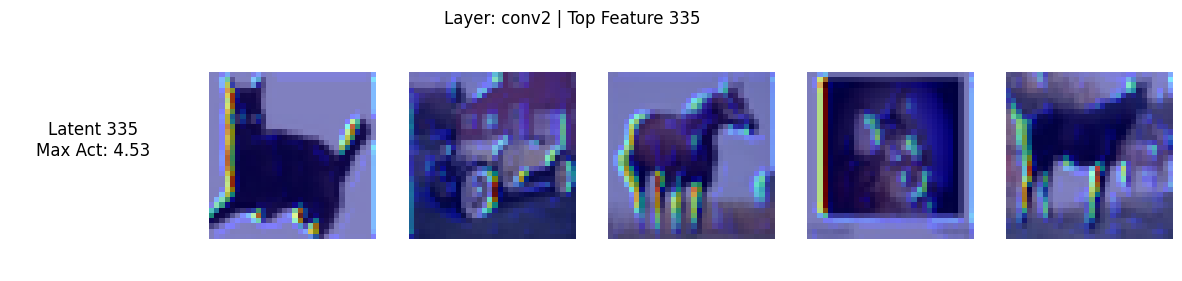

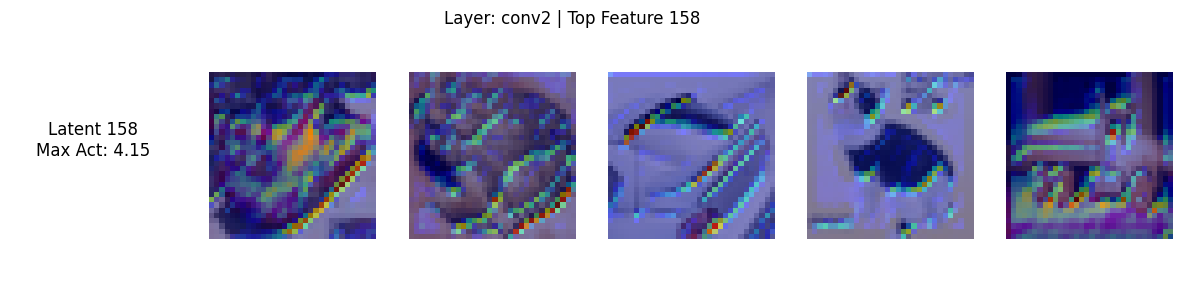

Analyzing conv3 to find most important features...


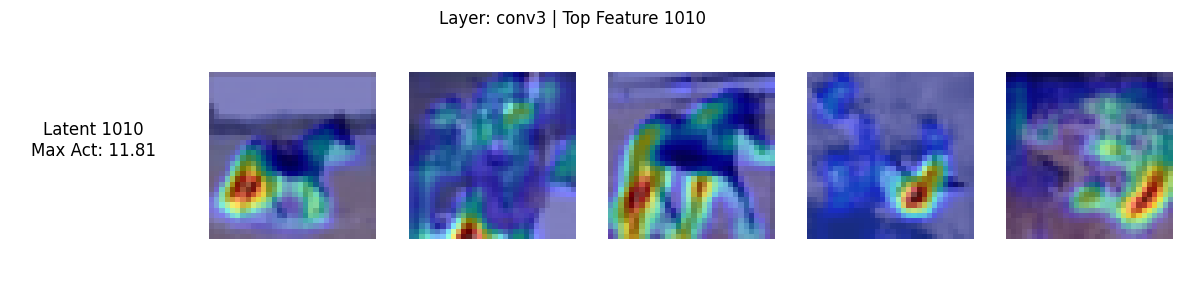

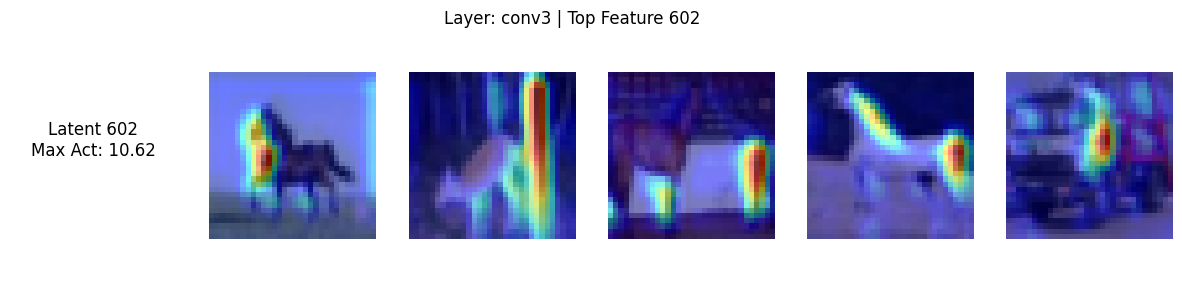

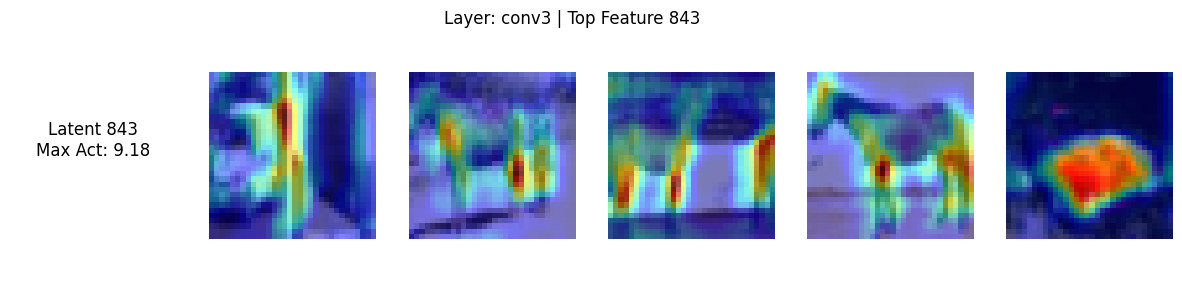

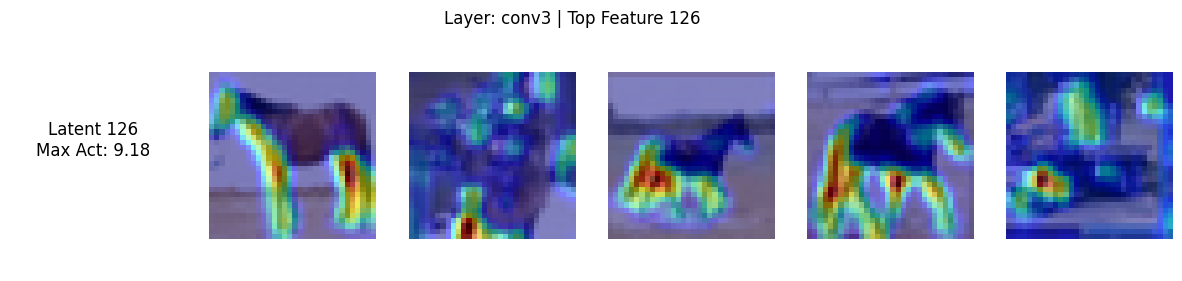

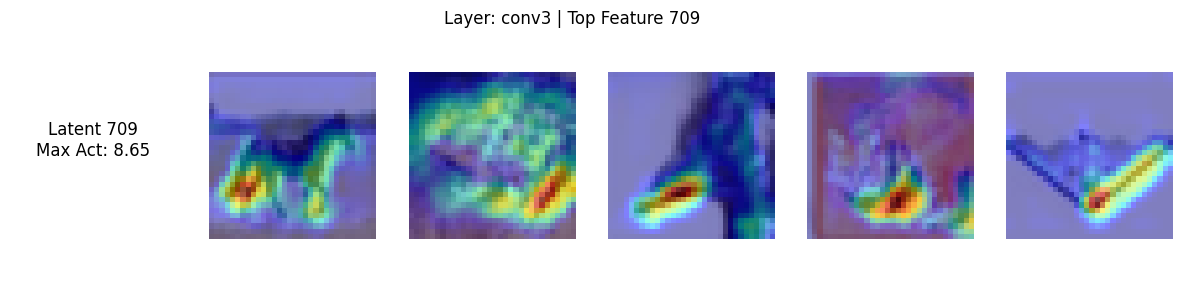

In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_sae_heatmap(cnn, sae, layer_name, trainloader, num_features=5, batches_to_scan=20):
    print(f"Analyzing {layer_name} to find most important features...")
    
    current_acts = {}
    def get_act(name):
        def hook(model, input, output):
            current_acts[name] = output.detach()
        return hook
    
    handle = getattr(cnn, layer_name).register_forward_hook(get_act(layer_name))
    
    feature_max_vals = {} 
    feature_top_imgs = {} 

    cnn.eval()
    sae.eval()
    
    with torch.no_grad():
        for i, (images, _) in enumerate(trainloader):
            if i >= batches_to_scan: break
            images = images.to(device)
            
            _ = cnn(images)
            act = current_acts[layer_name]
            b, c, h, w = act.shape
            
            act_flat = act.permute(0, 2, 3, 1).reshape(-1, c)
            _, latents = sae(act_flat)
            latents = latents.view(b, h, w, -1)
            
            batch_max_per_feature, _ = latents.view(b*h*w, -1).max(dim=0)
            
            for f_idx in range(latents.shape[-1]):
                current_max = batch_max_per_feature[f_idx].item()
                
                if f_idx not in feature_max_vals:
                    feature_max_vals[f_idx] = 0.0
                    feature_top_imgs[f_idx] = []

                if current_max > feature_max_vals[f_idx]:
                    feature_max_vals[f_idx] = current_max

                if current_max > 0.1:
                    feat_map = latents[:, :, :, f_idx]
                    img_maxes, _ = feat_map.view(b, -1).max(dim=1)
                    
                    for img_idx in range(b):
                        score = img_maxes[img_idx].item()
                        if score > 0.1:
                            heatmap = feat_map[img_idx].cpu()
                            img_data = images[img_idx].cpu()
                            
                            feature_top_imgs[f_idx].append((score, img_data, heatmap))
                            feature_top_imgs[f_idx].sort(key=lambda x: x[0], reverse=True)
                            feature_top_imgs[f_idx] = feature_top_imgs[f_idx][:5]

    handle.remove()
    
    sorted_features = sorted(feature_max_vals.items(), key=lambda x: x[1], reverse=True)
    top_indices = [x[0] for x in sorted_features[:num_features]]
    
    for feat_idx in top_indices:
        top_5 = feature_top_imgs.get(feat_idx, [])
        if len(top_5) == 0: continue
        
        fig, axs = plt.subplots(1, 6, figsize=(15, 3))
        axs[0].text(0.5, 0.5, f"Latent {feat_idx}\nMax Act: {feature_max_vals[feat_idx]:.2f}", 
                    ha='center', fontsize=12)
        axs[0].axis('off')
        
        for j, (score, img, hmap) in enumerate(top_5):
            img = img / 2 + 0.5
            img = np.transpose(img.numpy(), (1, 2, 0))
            
            hmap = hmap.unsqueeze(0).unsqueeze(0)
            hmap = F.interpolate(hmap, size=(32,32), mode='bilinear')
            hmap = hmap.squeeze().numpy()
            
            axs[j+1].imshow(np.clip(img, 0, 1))
            axs[j+1].imshow(hmap, cmap='jet', alpha=0.5)
            axs[j+1].axis('off')
            
        plt.suptitle(f"Layer: {layer_name} | Top Feature {feat_idx}")
        plt.show()

visualize_sae_heatmap(cnn, saes['conv1'], 'conv1', trainloader, num_features=5)
visualize_sae_heatmap(cnn, saes['conv2'], 'conv2', trainloader, num_features=5)
visualize_sae_heatmap(cnn, saes['conv3'], 'conv3', trainloader, num_features=5)